# Electron Photon tagging

This is a first test to implement a QAE. 
The task is to identify Electrons and Photons from em-calorimeter images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses
import h5py
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

2022-07-28 11:30:25.436320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 11:30:25.436348: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-28 11:30:27.061399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-28 11:30:27.061435: W tensorflow/

In [2]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

In [3]:
electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

In [4]:
x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [5]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [6]:
x_train = x_train.reshape(x_train.shape + (1,))
x_train_electrons = x_train_electrons.reshape(x_train_electrons.shape + (1,))

x_val = x_val.reshape(x_val.shape + (1,))
x_val_electrons = x_val_electrons.reshape(x_val_electrons.shape + (1,))

x_test = x_test.reshape(x_test.shape + (1,))
x_test_electrons = x_test_electrons.reshape(x_test_electrons.shape + (1,))

In [7]:
max_norm = np.max(x_train)
x_train = x_train / max_norm
x_train_electrons = x_train_electrons / max_norm

x_val = x_val / max_norm
x_val_electrons = x_val_electrons / max_norm

x_test = x_test / max_norm
x_test_electrons = x_test_electrons / max_norm

In [8]:
ae = cae.Convolutional_Autoencoder_gamma_e(128)

In [9]:
ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0005))

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.00001)
hist = ae.fit(x_train,x_train,
                epochs=50,
                shuffle=True,
                batch_size=200,
                validation_data=(x_val,x_val),
                callbacks=[es])

Epoch 1/50
597/597 [==============================] - 112s 186ms/step - loss: 0.0237 - val_loss: 0.0026
Epoch 2/50
597/597 [==============================] - 122s 205ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/50
597/597 [==============================] - 115s 193ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/50
597/597 [==============================] - 119s 200ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/50
597/597 [==============================] - 120s 201ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/50
597/597 [==============================] - 111s 187ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/50
597/597 [==============================] - 111s 186ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/50
597/597 [==============================] - 114s 190ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/50
597/597 [==============================] - 118s 197ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/50
597/597 [==============================] - 115s 193m

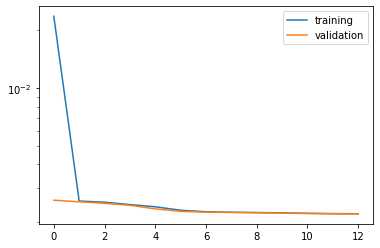

In [11]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [12]:
from hep_VQAE import utils as ut

Collapse_metric: 0.93
Average EMD: 0.269
ssim: 0.998
MAE: 0.000128
normalized MAE: 0.000152


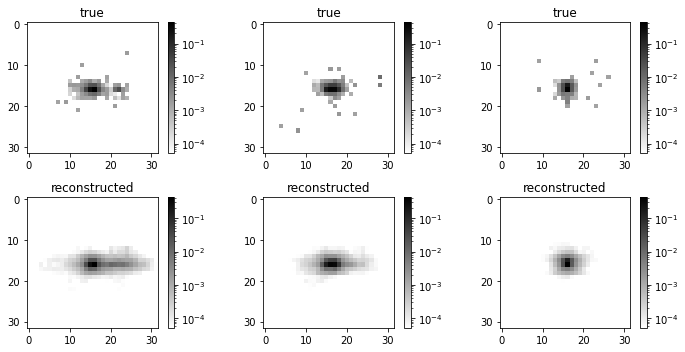

In [23]:
recon = ae.predict(x_test[:1000])

ut.eval_recon(x_test[:1000], recon, lognorm=True)

Median background: 0.00203
Median signal: 0.00228
Maximum accuracy: 0.613
AUC: 0.631


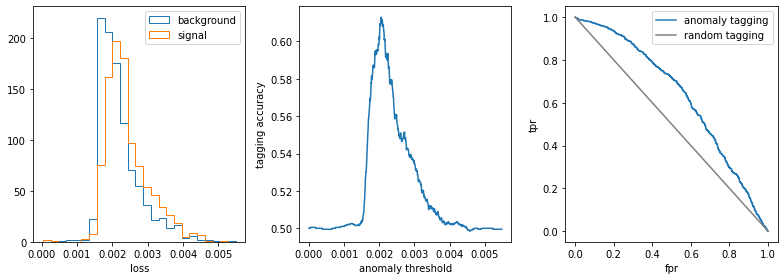

In [21]:
recon = ae.predict(x_test[:1000])
recon_e = ae.predict(x_test_electrons[:1000])

ut.eval_tagging(x_test[:1000], recon, x_test_electrons[:1000], recon_e)